***Tarea Final - Herramientas Computacionales***



Presentado por: *Brayan Santiago Amorocho Lizcano (2210719)*

In [1]:
#Importamos algunas bibliotecas importantes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci
from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d


In [2]:
#Lectura de datos. Los datos están en la carpeta del repositorio ;)

GAP_read =pd.read_csv("../data/Global_active_power.csv")
GI_read =pd.read_csv("../data/Global_intensity.csv")
GRP_read =pd.read_csv("../data/Global_reactive_power.csv")
VO_read =pd.read_csv("../data/Voltage.csv")

Una vez leídos los archivos, procedemos a juntarlos:

In [3]:
data1 = pd.merge(GAP_read,GI_read, on=["Datetime"])
data2 = pd.merge(GRP_read,VO_read, on=["Datetime"])
data = pd.merge(data1,data2, on=["Datetime"])


#Ahora convertimos los datos a vatios/hora
data["Global_active_power"] = round(data["Global_active_power"]*1000/60, 3)
data["Global_reactive_power"] = round(data["Global_reactive_power"]*1000/60, 3)
data


,Datetime,Global_active_power,Global_intensity,Global_reactive_power,Voltage
0,2010-01-01 00:00:00,29.833,7.4,3.933,240.65
1,2010-01-01 00:01:00,29.667,7.4,3.900,240.07
2,2010-01-01 00:02:00,29.667,7.4,3.900,240.15
3,2010-01-01 00:03:00,29.100,7.2,3.100,240.26
4,2010-01-01 00:04:00,28.100,7.0,1.700,240.12
...,...,...,...,...,...
457390,2010-11-26 20:58:00,15.767,4.0,0.000,240.43
457391,2010-11-26 20:59:00,15.733,4.0,0.000,240.00
457392,2010-11-26 21:00:00,15.633,3.8,0.000,239.82
457393,2010-11-26 21:01:00,15.567,3.8,0.000,239.70


Antes de hacer el resample, es necesario ajustar el Datetime para que Pandas no nos ponga problemas

In [4]:
data["Datetime"]=pd.to_datetime(data["Datetime"])
data= data.set_index("Datetime")
#Básicamente cambiamos la forma de la columna "Datetime" (Que era tipo Object) a una que Pandas pueda leer y convertir ;)

Ahora procedemos a hacer el *resample*.

In [5]:
#En días
data_d = data.resample("D").mean()

#Revisamos que no haya algún infinito o 0 que dañe los resultados:
data_d.replace([np.inf, -np.inf, 0], np.nan, inplace=True)
data_d.dropna(inplace=True) 
#Pd: Lo hago solo con este pq en el de los meses se puede ver que de por sí no hay vacíos o NaN

data_d

,Global_active_power,Global_intensity,Global_reactive_power,Voltage
Datetime,,,,
2010-01-01,14.169592,3.537083,1.913614,242.565722
2010-01-02,19.603921,4.857778,1.444256,243.631743
2010-01-03,15.031576,3.757778,1.505511,241.822778
2010-01-04,19.530563,4.879028,1.672035,241.754160
2010-01-05,15.279607,3.929861,2.228298,240.647167
...,...,...,...,...
2010-12-07,12.842301,3.397222,3.309176,240.218646
2010-12-08,6.130765,1.623750,1.957152,240.794931
2010-12-09,18.658474,4.755694,2.330551,241.619722


In [6]:
#En meses
data_m = data.resample("M").mean()
data_m

,Global_active_power,Global_intensity,Global_reactive_power,Voltage
Datetime,,,,
2010-01-31,21.677334,5.430332,2.086377,242.338522
2010-02-28,19.292318,4.836624,1.824457,242.002101
2010-03-31,19.500255,4.920399,2.272798,241.475284
2010-04-30,17.272230,4.363496,2.159279,241.442527
2010-05-31,17.932618,4.551504,2.120356,241.296151
2010-06-30,16.255105,4.170282,2.425415,240.888985
2010-07-31,12.982458,3.337202,2.301545,240.965167
2010-08-31,15.490872,3.954423,2.180260,241.422944
2010-09-30,16.625685,4.223837,2.128339,241.267517


# Modelo de regresión


**1**. Relación entre Global_Active_Power (GAP) y Global Intensity (GI).

$GAP = A_{1}GI+B_{1} $

Para hacerlo más sencillo, es como decir
$y = f(x) = mx+b $, por lo tanto, es correcto decir que la GAP depende de la GI.

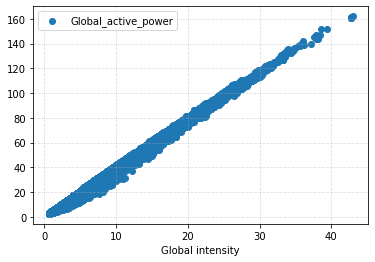

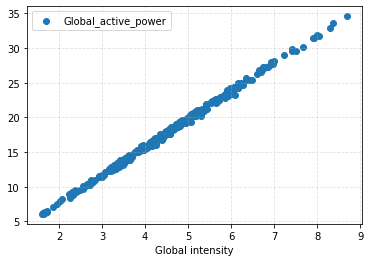

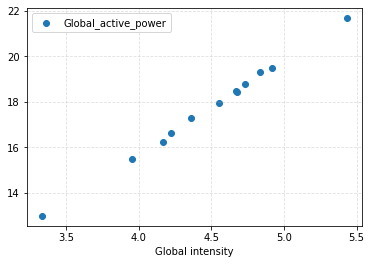

In [7]:
#Graficamos para encontrar la relación
#Sin hacer resample
plt.figure()
plt.scatter(data["Global_intensity"], data["Global_active_power"], label="Global_active_power")
plt.xlabel("Global intensity")
plt.legend()
plt.grid(linestyle="--", alpha =0.4)
#Resample días
plt.figure()
plt.scatter(data_d["Global_intensity"], data_d["Global_active_power"], label="Global_active_power")
plt.xlabel("Global intensity")
plt.legend()
plt.grid(linestyle="--", alpha =0.4)
#Resample meses
plt.figure()
plt.scatter(data_m["Global_intensity"], data_m["Global_active_power"], label="Global_active_power")
plt.xlabel("Global intensity")
plt.legend()
plt.grid(linestyle="--", alpha =0.4)
 

plt.show()

Efectivamente, hay una relación lineal.

In [8]:
#Definimos la función de la recta y hallamos los coeficientes

def func1(x, m, b):
    return m*x+b

popt1, pcov1 = curve_fit(func1, data["Global_intensity"], data["Global_active_power"])
popt2, pcov2 = curve_fit(func1, data_d["Global_intensity"], data_d["Global_active_power"])
popt3, pcov3 = curve_fit(func1, data_m["Global_intensity"], data_m["Global_active_power"])

#print(popt1, popt2, popt3)
#print(pcov1, pcov2, pcov3)

#Sacamos la varianza:
cov1 = np.sqrt(np.diag(pcov1))
cov2 = np.sqrt(np.diag(pcov2))
cov3 = np.sqrt(np.diag(pcov3))
print("La varianza es m1=%5.7f y b1=%5.7f" % tuple(cov1))
print("La varianza es m2=%5.7f y b2=%5.7f" % tuple(cov2))
print("La varianza es m3=%5.7f y b3=%5.7f" % tuple(cov3))

La varianza es m1=0.0003101 y b1=0.0018445
La varianza es m2=0.0100073 y b2=0.0470390
La varianza es m3=0.0425963 y b3=0.1924679


Ahora podemos comparar:

Los coeficientes son m1=3.967 y b1=-0.083
Los coeficientes son m2=4.051 y b2=-0.459
Los coeficientes son m3=4.174 y b3=-1.011


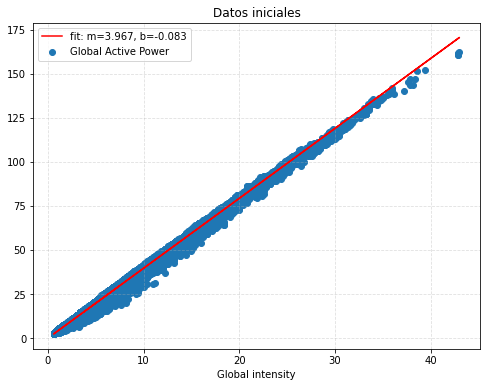

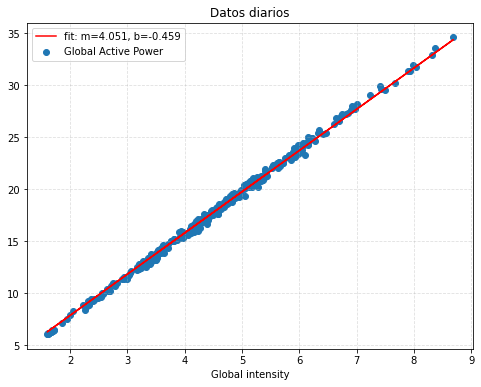

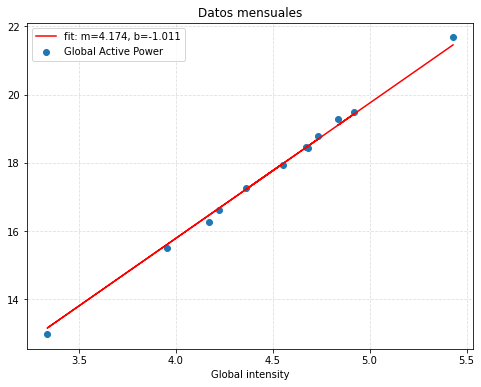

In [9]:
#Sin hacer resample
plt.figure(figsize=(8,6))
plt.scatter(data["Global_intensity"], data["Global_active_power"], label="Global Active Power")
plt.plot(data["Global_intensity"], func1(data["Global_intensity"],*popt1), "r-", label="fit: m=%5.3f, b=%5.3f" % tuple(popt1))
plt.xlabel("Global intensity")
plt.legend()
plt.title("Datos iniciales")
plt.grid(linestyle="--", alpha =0.4)
print("Los coeficientes son m1=%5.3f y b1=%5.3f" % tuple(popt1))
#Resample días
plt.figure(figsize=(8,6))
plt.scatter(data_d["Global_intensity"], data_d["Global_active_power"], label="Global Active Power")
plt.plot(data_d["Global_intensity"], func1(data_d["Global_intensity"],*popt1 ),"r-", label="fit: m=%5.3f, b=%5.3f" % tuple(popt2))
plt.xlabel("Global intensity")
plt.legend()
plt.title("Datos diarios")
plt.grid(linestyle="--", alpha =0.4)
print("Los coeficientes son m2=%5.3f y b2=%5.3f" % tuple(popt2))
#Resample meses
plt.figure(figsize=(8,6))
plt.scatter(data_m["Global_intensity"], data_m["Global_active_power"], label="Global Active Power")
plt.plot(data_m["Global_intensity"], func1(data_m["Global_intensity"],*popt1 ),"r-", label="fit: m=%5.3f, b=%5.3f" % tuple(popt3))
plt.xlabel("Global intensity")
plt.legend()
plt.title("Datos mensuales")
plt.grid(linestyle="--", alpha =0.4)
print("Los coeficientes son m3=%5.3f y b3=%5.3f" % tuple(popt3))


Podemos ver que la pendiente y el punto de corte con el eje Y son diferentes según el caso. Además, en la celda superior vemos la varianza tanto de la pendiente m como en el punto de corte b (también según el caso).
En el primer caso (Cuando tenemos en cuenta todos los datos), la pendiente es de $m_{1} = 3.967 \pm 0.0003101$ y el punto de corte es $ b_{1} = -0.083 \pm 0.0018$. En el caso 2 (Tomando en cuenta los datos diarios) dicen que $m_{2} = 4.051 \pm 0.01 $ y $b_{2} = -0.459 \pm 0.047$. Finalmente, cuando tomamos los casos mensuales vemos que $m_{3} = 4.174  \pm 0.0425 $ y $b_{3} = -1.011 \pm 0.192$. Podemos ver que los valores de las pendientes van aumentando a medida que disminuyen los datos, mientras que los valores de $b$, por el contrario, disminuyen.

**Coeficiente de Pearson**
Con el fin de definir qué tan acertados son estos datos, procedemos a calcular el coeficiente de Pearson (Visto y explicado en clase), se recomienda que este número no sea mayor al 20%, así que se eligirá el menor valor para tomar el modelo más adecuado.

In [10]:
#Calculando el coeficiente de Pearson

def pearson(a,desv):
    return desv / a * 100
print("El número de pearson en m1 es de: %2.7f, y en b1 de: %2.7f." % tuple(pearson(popt1,cov1)))
print("EL número de pearson en m2 es de: %2.7f, y en b2 de: %2.7f." % tuple(pearson(popt2,cov2)))
print("EL número de pearson en m3 es de: %2.7f, y en b3 de: %2.7f." % tuple(pearson(popt3,cov3)))

El número de pearson en m1 es de: 0.0078167, y en b1 de: -2.2213381.
EL número de pearson en m2 es de: 0.2470347, y en b2 de: -10.2510466.
EL número de pearson en m3 es de: 1.0205620, y en b3 de: -19.0335777.


Por lo tanto, podemos ver que el valor más acertado es el del caso 1. Lo cual tiene sentido, entre más datos es más sencillo dar una estimación de los coeficientes más precisa. Por lo tanto, es posible afirmar que la fórmula que relaciona las variables Global_Active_Power (GAP) y Global Intensity (GI) es:

$GAP = m{1}GI+B_{1} $, donde $m_{1} = 3.967 \pm 0.0003101$ y $ b_{1} = -0.083 \pm 0.0018$ 


**2**. Relación entre Global_Active_Power (GAP) y Voltage (VO).

$GAP = A_{2}VO+B_{2} $


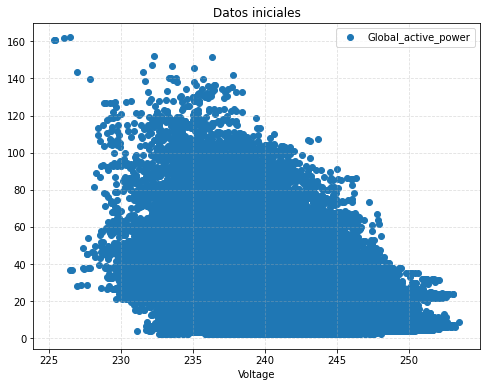

In [11]:
#Graficamos para encontrar la relación
plt.figure(figsize=(8,6))
plt.subplot()
plt.scatter(data["Voltage"], data["Global_active_power"], label="Global_active_power")
plt.legend()
plt.grid(linestyle="--", alpha =0.4)
plt.title("Datos iniciales")
plt.xlabel("Voltage")
plt.show()

Parece que los datos están muy dispersos, veamos si podemos encontrar la relación y qué tan alto es el margen de error.

Para no hacer esto tan repetitivo, me guiaré de la función automatizada vista en clase para sacar estos valores de forma más rápida y sin tantas variables:

In [12]:
def get_fit(func, x, y, xlabel, name, title):
    popt, pcov = curve_fit(func, x, y)
    cov = np.sqrt(np.diag(pcov))
    
    popt, cov = np.around(popt,4), np.around(cov,4)
    plt.figure(figsize=(8,6))
    plt.plot(x,func(x,*popt), "r-", label = r"fit:{}$\pm${}".format(np.around(tuple(popt),2),tuple(cov)))
    plt.scatter(x,y,label=name)
    plt.xlabel(xlabel)
    plt.legend()
    plt.grid(linestyle="--", alpha =0.4)
    plt.title(title)
    plt.show()
    print("Los coeficientes son m= {} y b={}".format(popt[0],popt[1]))
    print("Margen de error de m={} y b= {}".format(cov[0],cov[1]))
    print("Número de pearson en m es de", round(pearson(popt[0],cov[0]),4))
    print("Número de pearson en b es de", round(pearson(popt[1],cov[1]),4))
    

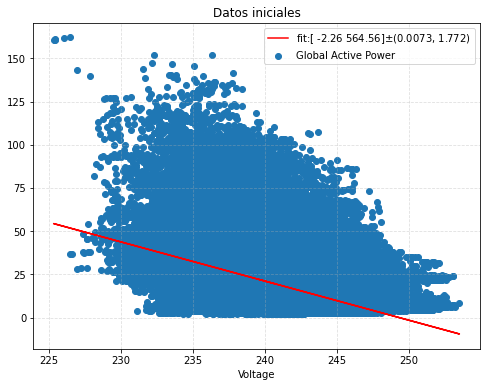

Los coeficientes son m= -2.2643 y b=564.5588
Margen de error de m=0.0073 y b= 1.772
Número de pearson en m es de -0.3224
Número de pearson en b es de 0.3139


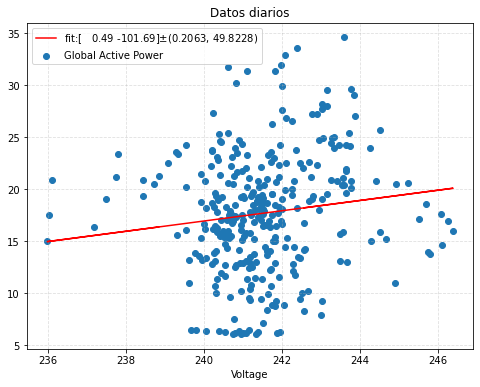

Los coeficientes son m= 0.4943 y b=-101.6942
Margen de error de m=0.2063 y b= 49.8228
Número de pearson en m es de 41.7358
Número de pearson en b es de -48.9928


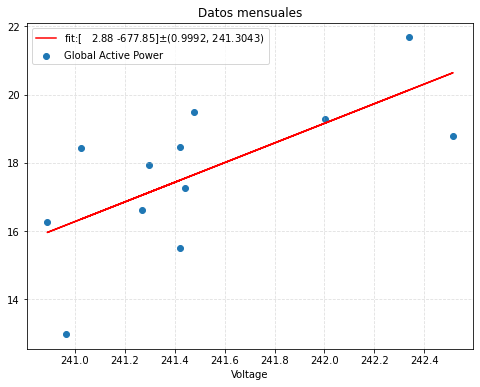

Los coeficientes son m= 2.8802 y b=-677.8497
Margen de error de m=0.9992 y b= 241.3043
Número de pearson en m es de 34.692
Número de pearson en b es de -35.5985


In [13]:
#Ahora calculamos para los 3 casos:
get_fit(func1,data["Voltage"],data["Global_active_power"], "Voltage", "Global Active Power", "Datos iniciales")
get_fit(func1,data_d["Voltage"],data_d["Global_active_power"], "Voltage", "Global Active Power", "Datos diarios")
get_fit(func1,data_m["Voltage"],data_m["Global_active_power"], "Voltage", "Global Active Power", "Datos mensuales")

Según estos datos, la mejor pendiente y el mejor punto de corte para cada caso son de:
   
$m_{1} = -2.2643  \pm 0.0073$ y $ b_{1} = 564.56 \pm 1.772$. 

$m_{2} = 0.4943   \pm 0.2063  $ y $b_{2} = -101.6942 \pm 49.8228$.

$m_{3} = 2.8802   \pm 0.9992  $ y $b_{3} = -677.8497 \pm 241.3043$. 

Se puede ver que son muy variadas y no se ven muy acertadas, sin embargo, al calcular el número de pearson (P) se obtienen los siguientes resultados:

$Pm_{1} = -0.3224 \% $ y $ Pb_{1} = 0.3139\%$. 

$Pm_{2} = 41.7358\%$ y $Pb_{2} = -48.9928\%$.

$Pm_{3} = 34.692  \%$ y $Pb_{3} = -35.5985\%$. 


Lo que nos indica que tanto el caso 2 como el caso 3 no sirven, porque tienen un número de pearson mayor al 20%. Y no son aptos.

Por otra parte, vemos que el caso de la función cuadrática ($ax^{2} + bx + c$)nos dice que    
$a_{1} = 0.0108  \pm 0.0015$, $ b_{1} = -89.2303 \pm 0.7266$ y $ c_{1} = 663.63 \pm 5.262$. Con números de pearson de $Pm_{1} = 0.8329 \% $, $ Pb_{1} = 0.8144\%$ y  $ Pc_{1} = 0.7929\%$.

Por lo tanto, podría decirse el modelo más apropiado es el primero ($m_{1} y b_{1}), puesto que presenta el menor error.


**3**. Relación entre Global_Active_Power (GAP), Global Intensity (GI) y Voltage (VO).

$GAP = A_{31}GI+ A_{32}VO + B_{3} $

Este caso es algo más complicado, puesto que combina dos variables. Pero de igual forma, gracias a las relaciones obtenidas anteriormente es posible dar con los coeficientes.

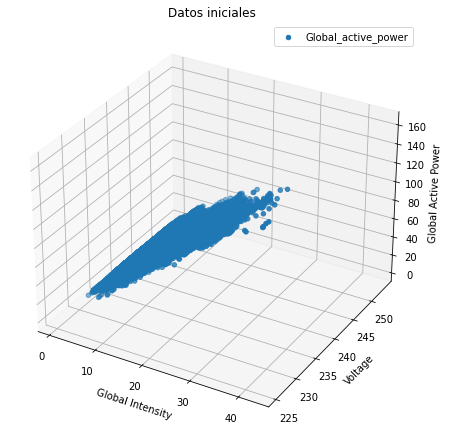

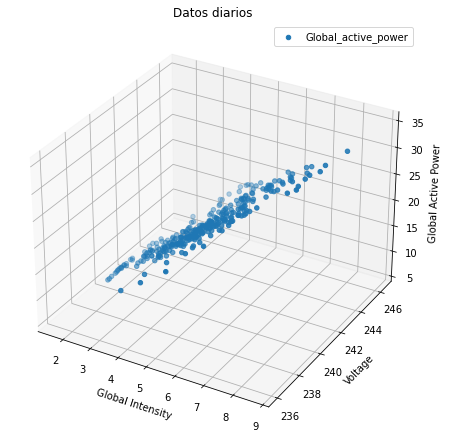

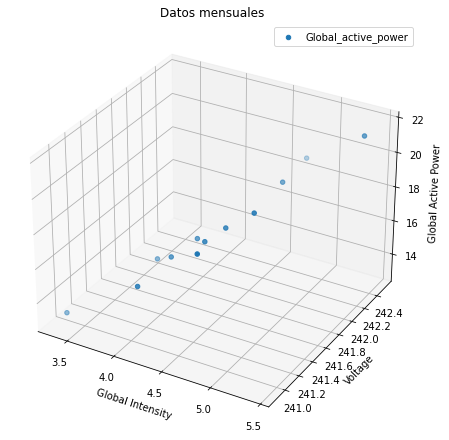

In [14]:
#Como tenemos dos variables, la gráfica nos dará en tres dimensiones:

fig=plt.figure(figsize=(8,6))
axes = plt.axes(projection="3d")
axes.scatter3D(data["Global_intensity"],data["Voltage"], data["Global_active_power"], label="Global_active_power")
axes.set_xlabel("Global Intensity")
axes.set_ylabel("Voltage")
axes.set_zlabel("Global Active Power")
plt.tight_layout()
plt.legend()
plt.title("Datos iniciales")
plt.show()

fig=plt.figure(figsize=(8,6))
axes = plt.axes(projection="3d")
axes.scatter3D(data_d["Global_intensity"],data_d["Voltage"], data_d["Global_active_power"], label="Global_active_power")
axes.set_xlabel("Global Intensity")
axes.set_ylabel("Voltage")
axes.set_zlabel("Global Active Power")
plt.tight_layout()
plt.legend()
plt.title("Datos diarios")
plt.show()

fig=plt.figure(figsize=(8,6))
axes = plt.axes(projection="3d")
axes.scatter3D(data_m["Global_intensity"],data_m["Voltage"], data_m["Global_active_power"], label="Global_active_power")
axes.set_xlabel("Global Intensity")
axes.set_ylabel("Voltage")
axes.set_zlabel("Global Active Power")
plt.tight_layout()
plt.title("Datos mensuales")
plt.legend()
plt.show()

Como era de esperarse, la gráfica es de tres dimensiones (Puesto que tenemos dos variables independientes), ahora procedemos a hacer el análisis de regresión con curve_fit:

In [15]:
#Definimos la función
def func3(X, a, b, c):
    x = X[0]
    y = X[1]
    return a*x + b*y + c

popt1, pcov1 = curve_fit(func3, (data["Global_intensity"], data["Voltage"]), data["Global_active_power"])
popt2, pcov2 = curve_fit(func3, (data_d["Global_intensity"], data_d["Voltage"]), data_d["Global_active_power"])
popt3, pcov3 = curve_fit(func3, (data_m["Global_intensity"], data_m["Voltage"]), data_m["Global_active_power"])

#Ahora calculamos la varianza
cov1 = np.around(np.sqrt(np.diag(pcov1)),4)
cov2 = np.around(np.sqrt(np.diag(pcov2)),4)
cov3 = np.around(np.sqrt(np.diag(pcov3)),4)
print("La varianza es a11= %5.7f, a12= %5.7f y b = %5.7f." % tuple(cov1))
print("La varianza es a11= %5.7f, a12= %5.7f y b = %5.7f." % tuple(cov2))
print("La varianza es a11= %5.7f, a12= %5.7f y b = %5.7f." % tuple(cov3))

#Redondeamos algunos valores
popt1 = np.around(popt1,4)
popt2 = np.around(popt2,4)
popt3 = np.around(popt3,4)


La varianza es a11= 0.0003000, a12= 0.0005000 y b = 0.1109000.
La varianza es a11= 0.0079000, a12= 0.0073000 y b = 1.7521000.
La varianza es a11= 0.0402000, a12= 0.0412000 y b = 9.8236000.


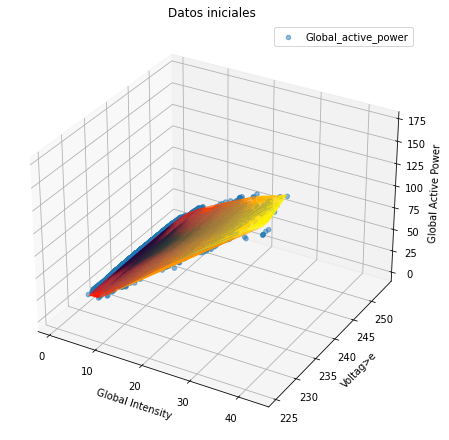

Los coeficientes son a11= 3.9913, a12 = 0.0778 y b1= -18.9863
Margen de error de a11= 0.0003, a12 = 0.0005 y b1= 0.1109
Número de Pearson en a11 es de 0.0075
Número de Pearson en a12 es de 0.6427
Número de Pearson en b1 es de -0.5841


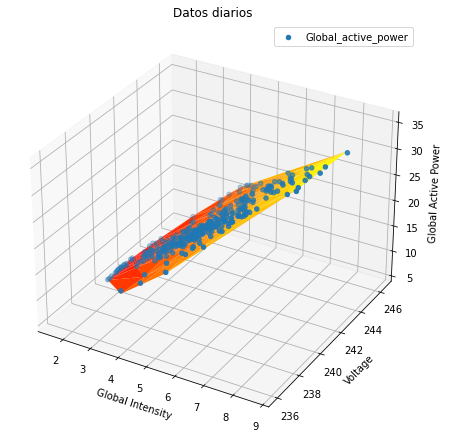

Los coeficientes son a11= 4.0392, a12 = 0.1029 y b1= -25.2543
Margen de error de a11= 0.0079, a12 = 0.0073 y b1= 1.7521
Número de Pearson en a11 es de 0.1956
Número de Pearson en a12 es de 7.0943
Número de Pearson en b1 es de -6.9378


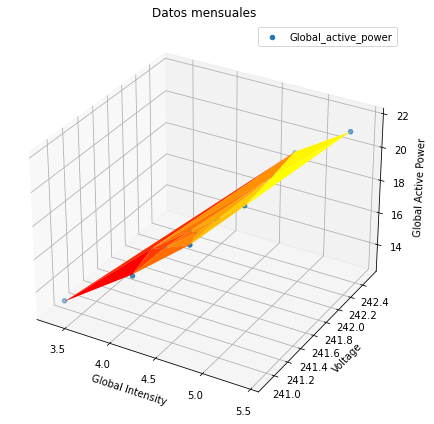

Los coeficientes son a11= 4.0875, a12 = 0.1347 y b1= -33.1514
Margen de error de a11= 0.0402, a12 = 0.0412 y b1= 9.8236
Número de Pearson en a11 es de 0.9835
Número de Pearson en a12 es de 30.5865
Número de Pearson en b1 es de -29.6325


In [16]:
#Ahora las gráficas:
#Sin hacer resample
"""
En las siguientes líneas simplemente hago las gráficas que se muestran abajo e imprimo los datos de coeficientes, 
margen de error y número de Pearson. Elegí hacer un plano en lugar de líneas puesto que estamos trabajando en un espacio 
tridimensional (Con dos variables independientes), así se ven mejor los resultados ;)
"""

fig=plt.figure(figsize=(8,6))
axes = plt.axes(projection="3d")
axes.scatter3D(data["Global_intensity"],data["Voltage"], data["Global_active_power"], label="Global_active_power", alpha=0.5)
axes.plot_trisurf(data["Global_intensity"], data["Voltage"], func3((data["Global_intensity"],data["Voltage"]),*popt1), cmap='autumn')
#axes.plot3D(data["Global_intensity"], data["Voltage"], func3((data["Global_intensity"],data["Voltage"]),*popt1), "r-", label=r"fit: $a_{11}$ =%5.3f, $a_{12}$ = %5.3f y $b_{1}$ =%5.3f" % tuple(popt1))
axes.set_xlabel("Global Intensity")
axes.set_ylabel("Voltag>e")
axes.set_zlabel("Global Active Power")
plt.tight_layout()
plt.title("Datos iniciales")
plt.legend()
plt.show()

print("Los coeficientes son a11= {}, a12 = {} y b1= {}".format(popt1[0],popt1[1],popt1[2]))
print("Margen de error de a11= {}, a12 = {} y b1= {}".format(cov1[0],cov1[1],cov1[2]))
print("Número de Pearson en a11 es de", round(pearson(popt1[0],cov1[0]),4))
print("Número de Pearson en a12 es de", round(pearson(popt1[1],cov1[1]),4))
print("Número de Pearson en b1 es de", round(pearson(popt1[2],cov1[2]),4))


fig=plt.figure(figsize=(8,6))
axes = plt.axes(projection="3d")
axes.scatter3D(data_d["Global_intensity"],data_d["Voltage"], data_d["Global_active_power"], label="Global_active_power")
axes.plot_trisurf(data_d["Global_intensity"], data_d["Voltage"], func3((data_d["Global_intensity"],data_d["Voltage"]),*popt2), cmap='autumn')
axes.set_xlabel("Global Intensity")
axes.set_ylabel("Voltage")
axes.set_zlabel("Global Active Power")
plt.tight_layout()
plt.title("Datos diarios")
plt.legend()
plt.show()

print("Los coeficientes son a11= {}, a12 = {} y b1= {}".format(popt2[0],popt2[1],popt2[2]))
print("Margen de error de a11= {}, a12 = {} y b1= {}".format(cov2[0],cov2[1],cov2[2]))
print("Número de Pearson en a11 es de", round(pearson(popt2[0],cov2[0]),4))
print("Número de Pearson en a12 es de", round(pearson(popt2[1],cov2[1]),4))
print("Número de Pearson en b1 es de", round(pearson(popt2[2],cov2[2]),4))


fig=plt.figure(figsize=(8,6))
axes = plt.axes(projection="3d")
axes.scatter3D(data_m["Global_intensity"],data_m["Voltage"], data_m["Global_active_power"], label="Global_active_power")
axes.plot_trisurf(data_m["Global_intensity"], data_m["Voltage"], func3((data_m["Global_intensity"],data_m["Voltage"]),*popt3), cmap='autumn')
axes.set_xlabel("Global Intensity")
axes.set_ylabel("Voltage")
axes.set_zlabel("Global Active Power")
plt.title("Datos mensuales")
plt.tight_layout()
plt.legend()
plt.show()
print("Los coeficientes son a11= {}, a12 = {} y b1= {}".format(popt3[0],popt3[1],popt3[2]))
print("Margen de error de a11= {}, a12 = {} y b1= {}".format(cov3[0],cov3[1],cov3[2]))
print("Número de Pearson en a11 es de", round(pearson(popt3[0],cov3[0]),4))
print("Número de Pearson en a12 es de", round(pearson(popt3[1],cov3[1]),4))
print("Número de Pearson en b1 es de", round(pearson(popt3[2],cov3[2]),4))


Para este último caso se puede observar que en el caso de los datos mensuales el modelo no es adecuado, puesto que presenta un número de Pearson considerablemente alto. Sin embargo, para los datos originales (por minuto) y los datos diarios, los modelos son más apropiados. Por lo tanto, los coeficientes que satisfacen la ecuación $GAP = A_{31}GI+ A_{32}VO + B_{3} $ son:

$A_{31} = 3.9913 \pm 0.0003, A_{32} = 0.0778 \pm 0.0005, B_{3} = -18.9864 \pm 0.1109 $ ó $A_{31} = 4.0392 \pm 0.0079, A_{32} = 0.1029 \pm 0.0073, B_{3} = -25.2545 \pm 1.752 $


# Conclusión

Como podemos observar, la relación más acertada es la de Global Active Power y Global Intensity. Mientras que la relación que menor acierto presenta es la de Global Active Power con el Voltaje, puesto que a medida que disminuimos los datos, el modelo se va haciendo cada vez más desacertado.
Además, los datos que menor margen de error presentaron fueron los datos iniciales. Lo cual es curioso, pues se esperaría que al ser iniciales estarían un poco más dispersos. Sin embargo, podría decirse que los datos mensuales y diarios en ciertos casos no brindaban información suficiente para que curve_fit hiciera bien su trabajo.